In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split

In [ ]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
def leaky_relu(z):
  return torch.where(z>0,z,0.01*z)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_subset, batch_size=300, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=300, shuffle=False)
test_loader = DataLoader(test_data, batch_size=300, shuffle=False)

In [ ]:
train_iter=iter(train_loader)
x_train,y_train=next(train_iter)
x_train=torch.flatten(x_train,2).squeeze(1)

In [ ]:
nhidden1=128
nhidden2=64
noutput=10

In [ ]:
w1=torch.randn(x_train.shape[1],nhidden1)*0.01
w1.requires_grad_(True)
b1=torch.zeros(1,nhidden1)
b1.requires_grad_(True)

w2=torch.randn(nhidden1,nhidden2)*0.01
w2.requires_grad_(True)
b2=torch.zeros(1,nhidden2)
b2.requires_grad_(True)

w3=torch.randn(nhidden2,noutput)*0.01
w3.requires_grad_(True)
b3=torch.zeros(1,noutput)
b3.requires_grad_(True)


gamma1=torch.ones(nhidden1)
gamma1.requires_grad_(True)
beta1=torch.zeros(nhidden1)
beta1.requires_grad_(True)

gamma2=torch.ones(nhidden2)
gamma2.requires_grad_(True)
beta2=torch.zeros(nhidden2)
beta2.requires_grad_(True)

dropout=0.5
alpha=0.01

In [ ]:
# 1st layer
z1=x_train@w1+b1
# 1st batch normalization
mean1=z1.mean(0,keepdim=True)
diff1=z1-mean1
diff1_sqr=diff1**2.0
diff1_sqr_mean=diff1_sqr.mean(0,keepdim=True)
std1=torch.sqrt(diff1_sqr_mean)
std1_inv=std1**-1.0
batchnorm1=diff1*std1_inv
batchout1=gamma1*batchnorm1+beta1
# 1st activation
leaky1=leaky_relu(batchout1)
# 1st dropout
mask1 = torch.bernoulli(torch.full_like(leaky1, 1 - dropout))
output1 = (mask1 * leaky1) / (1 - dropout)

# 2nd layer
z2=output1@w2+b2
# 2nd batch normalization
mean2=z2.mean(0,keepdim=True)
diff2=z2-mean2
diff2_sqr=diff2**2.0
diff2_sqr_mean=diff2_sqr.mean(0,keepdim=True)
std2=torch.sqrt(diff2_sqr_mean)
std2_inv=std2**-1.0
batchnorm2=diff2*std2_inv
batchout2=gamma2*batchnorm2+beta2
# 2nd activation
leaky2=leaky_relu(batchout2)
# 2nd dropout
mask2 = torch.bernoulli(torch.full_like(leaky2, 1 - dropout))
output2 = (mask2 * leaky2) / (1 - dropout)

# output layer
z3=output2@w3+b3
z3_max=z3.max(1,keepdim=True).values
norm_z3=z3-z3_max
exp_z3=torch.exp(norm_z3)
exp_sum=(exp_z3.sum(dim=1,keepdim=True))
exp_sum_inv=exp_sum**-1
probs=exp_z3*exp_sum_inv
logprobs=torch.log(probs)
loss=-logprobs[range(len(x_train)),y_train].mean()




w1.grad=None
b1.grad=None
w2.grad=None
b2.grad=None
for i in [batchout1,output2,output1,batchout2,batchnorm2,std2_inv,std2,diff2_sqr_mean,diff2_sqr,diff2,mean2,batchnorm1,std1_inv,std1,diff1_sqr_mean,diff1_sqr,diff1,mean1,z1,leaky1,z2,leaky2,z3,z3_max,norm_z3,exp_z3,exp_sum,probs,logprobs,exp_sum_inv]:
  i.retain_grad()
loss.backward()

In [ ]:
dlogprobs=torch.zeros_like(logprobs)
dlogprobs[range(len(x_train)),y_train]=-1.0/len(x_train)
dprobs=(1.0/probs)*dlogprobs
dexp_sum_inv=(exp_z3*dprobs).sum(1,keepdim=True)
dexp_z3=exp_sum_inv*dprobs
dexp_sum=(-exp_sum**-2)*dexp_sum_inv
dexp_z3+=torch.ones_like(exp_z3)*dexp_sum
dnorm_z3=torch.exp(norm_z3)*dexp_z3
dz3=dnorm_z3.clone()
dz3_max=(-dnorm_z3).sum(1,keepdim=True)
dz3+=torch.nn.functional.one_hot(z3.max(1).indices,num_classes=z3.shape[1])*dz3_max
dw3=output2.T@dz3
db3=dz3.sum(0,keepdim=True)
doutput2=dz3@w3.T

dleaky2=(doutput2*mask2)/ (1 - dropout)
dbatchout2=torch.where(batchout2>0,1,0.01)*dleaky2
dgamma2=(batchnorm2*dbatchout2).sum(0,keepdim=True)
dbeta2=dbatchout2.sum(0,keepdim=True)
dbatchnorm2=gamma2*dbatchout2
dstd2_inv=(diff2*dbatchnorm2).sum(0,keepdim=True)
ddiff2=std2_inv*dbatchnorm2
dstd2=-1.0*(std2**-2.0)*dstd2_inv
ddiff2_sqr_mean=0.5*(diff2_sqr_mean**-0.5)*dstd2
ddiff2_sqr=torch.ones_like(diff2_sqr)*ddiff2_sqr_mean/z2.shape[0]
ddiff2+=2*diff2*ddiff2_sqr
dz2=ddiff2.clone()
dmean2=-ddiff2.sum(0,keepdim=True)
dz2+=torch.ones_like(z2)*dmean2/z2.shape[0]
dw2=output1.T@dz2
db2=dz2.sum(0,keepdim=True)
doutput1=dz2@w2.T

dleaky1=(doutput1*mask1)/ (1 - dropout)
dbatchout1=torch.where(batchout1>0,1,0.01)*dleaky1
dgamma1=(batchnorm1*dbatchout1).sum(0,keepdim=True)
dbeta1=dbatchout1.sum(0,keepdim=True)
dbatchnorm1=gamma1*dbatchout1
dstd1_inv=(diff1*dbatchnorm1).sum(0,keepdim=True)
ddiff1=std1_inv*dbatchnorm1
dstd1=-1.0*(std1**-2.0)*dstd1_inv
ddiff1_sqr_mean=0.5*(diff1_sqr_mean**-0.5)*dstd1
ddiff1_sqr=torch.ones_like(diff1_sqr)*ddiff1_sqr_mean/z1.shape[0]
ddiff1+=2*diff1*ddiff1_sqr
dz1=ddiff1.clone()
dmean1=-ddiff1.sum(0,keepdim=True)
dz1+=torch.ones_like(z1)*dmean1/z1.shape[0]
dw1=x_train.T@dz1
db1=dz1.sum(0,keepdim=True)



cmp("dlogprobs",dlogprobs,logprobs)
cmp("dprobs",dprobs,probs)
cmp("dexp_sum_inv",dexp_sum_inv,exp_sum_inv)
cmp("dexp_sum",dexp_sum,exp_sum)
cmp("dexp_z3",dexp_z3,exp_z3)
cmp("dnorm_z3",dnorm_z3,norm_z3)
cmp("dz3_max",dz3_max,z3_max)
cmp("dz3",dz3,z3)
cmp("dw3",dw3,w3)
cmp("db3",db3,b3)
cmp("doutput2",doutput2,output2)

cmp("dleaky2",dleaky2,leaky2)
cmp("batchout2",dbatchout2,batchout2)
cmp("dgamma2",dgamma2,gamma2)
cmp("dbeta2",dbeta2,beta2)
cmp("dbatchnorm2",dbatchnorm2,batchnorm2)
cmp("dstd2_inv",dstd2_inv,std2_inv)
cmp("dstd2",dstd2,std2)
cmp("ddiff2_sqr_mean",ddiff2_sqr_mean,diff2_sqr_mean)
cmp("ddiff2_sqr",ddiff2_sqr,diff2_sqr)
cmp("ddiff2",ddiff2,diff2)
cmp("dmean2",dmean2,mean2)
cmp("dz2",dz2,z2)
cmp("doutput1",doutput1,output1)
cmp("dw2",dw2,w2)
cmp("db2",db2,b2)

cmp("dleaky1",dleaky1,leaky1)
cmp("dbatchout1",dbatchout1,batchout1)
cmp("dgamma1",dgamma1,gamma1)
cmp("dbeta1",dbeta1,beta1)
cmp("dbatchnorm1",dbatchnorm1,batchnorm1)
cmp("dstd1_inv",dstd1_inv,std1_inv)
cmp("dstd1",dstd1,std1)
cmp("ddiff2_sqr_mean",ddiff2_sqr_mean,diff2_sqr_mean)
cmp("ddiff2_sqr",ddiff2_sqr,diff2_sqr)
cmp("ddiff1",ddiff1,diff1)
cmp("dmean1",dmean1,mean1)
cmp("dz1",dz1,z1)
cmp("dw1",dw1,w1)
cmp("db1",db1,b1)

dlogprobs       | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
dexp_sum_inv    | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
dexp_sum        | exact: False | approximate: True  | maxdiff: 8.731149137020111e-11
dexp_z3         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
dnorm_z3        | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
dz3_max         | exact: False | approximate: True  | maxdiff: 7.566995918750763e-10
dz3             | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10
dw3             | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
db3             | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
doutput2        | exact: False | approximate: True  | maxdiff: 2.1827872842550278e-11
dleaky2         | exact: False | approximate: True  | maxdiff: 4.3655745685100555

In [ ]:
w1=torch.randn(x_train.shape[1],nhidden1)*0.01
w1.requires_grad_(False)
b1=torch.zeros(1,nhidden1)
b1.requires_grad_(False)

w2=torch.randn(nhidden1,nhidden2)*0.01
w2.requires_grad_(False)
b2=torch.zeros(1,nhidden2)
b2.requires_grad_(False)

w3=torch.randn(nhidden2,noutput)*0.01
w3.requires_grad_(False)
b3=torch.zeros(1,noutput)
b3.requires_grad_(False)


gamma1=torch.ones(nhidden1)
gamma1.requires_grad_(False)
beta1=torch.zeros(nhidden1)
beta1.requires_grad_(False)

gamma2=torch.ones(nhidden2)
gamma2.requires_grad_(False)
beta2=torch.zeros(nhidden2)
beta2.requires_grad_(False)

dropout=0.5
alpha=0.01

In [ ]:
train_loss=[]
val_loss=[]
for i in range(100):
  batch_loss=[]
  for x_train,y_train in train_loader:
    x_train=torch.flatten(x_train,2).squeeze(1)
    # 1st layer
    z1=x_train@w1+b1
    # 1st batch normalization
    mean1=z1.mean(0,keepdim=True)
    diff1=z1-mean1
    diff1_sqr=diff1**2.0
    diff1_sqr_mean=diff1_sqr.mean(0,keepdim=True)
    std1=torch.sqrt(diff1_sqr_mean)
    std1_inv=std1**-1.0
    batchnorm1=diff1*std1_inv
    batchout1=gamma1*batchnorm1+beta1
    # 1st activation
    leaky1=leaky_relu(batchout1)
    # 1st dropout
    mask1 = torch.bernoulli(torch.full_like(leaky1, 1 - dropout))
    output1 = (mask1 * leaky1) / (1 - dropout)

    # 2nd layer
    z2=output1@w2+b2
    # 2nd batch normalization
    mean2=z2.mean(0,keepdim=True)
    diff2=z2-mean2
    diff2_sqr=diff2**2.0
    diff2_sqr_mean=diff2_sqr.mean(0,keepdim=True)
    std2=torch.sqrt(diff2_sqr_mean)
    std2_inv=std2**-1.0
    batchnorm2=diff2*std2_inv
    batchout2=gamma2*batchnorm2+beta2
    # 2nd activation
    leaky2=leaky_relu(batchout2)
    # 2nd dropout
    mask2 = torch.bernoulli(torch.full_like(leaky2, 1 - dropout))
    output2 = (mask2 * leaky2) / (1 - dropout)

    # output layer
    z3=output2@w3+b3
    z3_max=z3.max(1,keepdim=True).values
    norm_z3=z3-z3_max
    exp_z3=torch.exp(norm_z3)
    exp_sum=(exp_z3.sum(dim=1,keepdim=True))
    exp_sum_inv=exp_sum**-1
    probs=exp_z3*exp_sum_inv
    logprobs=torch.log(probs)
    loss=-logprobs[range(len(x_train)),y_train].mean()
    batch_loss.append(loss.item())

    # backpropagation
    dlogprobs=torch.zeros_like(logprobs)
    dlogprobs[range(len(x_train)),y_train]=-1.0/len(x_train)
    dprobs=(1.0/probs)*dlogprobs
    dexp_sum_inv=(exp_z3*dprobs).sum(1,keepdim=True)
    dexp_z3=exp_sum_inv*dprobs
    dexp_sum=(-exp_sum**-2)*dexp_sum_inv
    dexp_z3+=torch.ones_like(exp_z3)*dexp_sum
    dnorm_z3=torch.exp(norm_z3)*dexp_z3
    dz3=dnorm_z3.clone()
    dz3_max=(-dnorm_z3).sum(1,keepdim=True)
    dz3+=torch.nn.functional.one_hot(z3.max(1).indices,num_classes=z3.shape[1])*dz3_max
    dw3=output2.T@dz3
    db3=dz3.sum(0,keepdim=True)
    doutput2=dz3@w3.T

    dleaky2=(doutput2*mask2)/ (1 - dropout)
    dbatchout2=torch.where(batchout2>0,1,0.01)*dleaky2
    dgamma2=(batchnorm2*dbatchout2).sum(0,keepdim=True)
    dbeta2=dbatchout2.sum(0,keepdim=True)
    dbatchnorm2=gamma2*dbatchout2
    dstd2_inv=(diff2*dbatchnorm2).sum(0,keepdim=True)
    ddiff2=std2_inv*dbatchnorm2
    dstd2=-1.0*(std2**-2.0)*dstd2_inv
    ddiff2_sqr_mean=0.5*(diff2_sqr_mean**-0.5)*dstd2
    ddiff2_sqr=torch.ones_like(diff2_sqr)*ddiff2_sqr_mean/z2.shape[0]
    ddiff2+=2*diff2*ddiff2_sqr
    dz2=ddiff2.clone()
    dmean2=-ddiff2.sum(0,keepdim=True)
    dz2+=torch.ones_like(z2)*dmean2/z2.shape[0]
    dw2=output1.T@dz2
    db2=dz2.sum(0,keepdim=True)
    doutput1=dz2@w2.T

    dleaky1=(doutput1*mask1)/ (1 - dropout)
    dbatchout1=torch.where(batchout1>0,1,0.01)*dleaky1
    dgamma1=(batchnorm1*dbatchout1).sum(0,keepdim=True)
    dbeta1=dbatchout1.sum(0,keepdim=True)
    dbatchnorm1=gamma1*dbatchout1
    dstd1_inv=(diff1*dbatchnorm1).sum(0,keepdim=True)
    ddiff1=std1_inv*dbatchnorm1
    dstd1=-1.0*(std1**-2.0)*dstd1_inv
    ddiff1_sqr_mean=0.5*(diff1_sqr_mean**-0.5)*dstd1
    ddiff1_sqr=torch.ones_like(diff1_sqr)*ddiff1_sqr_mean/z1.shape[0]
    ddiff1+=2*diff1*ddiff1_sqr
    dz1=ddiff1.clone()
    dmean1=-ddiff1.sum(0,keepdim=True)
    dz1+=torch.ones_like(z1)*dmean1/z1.shape[0]
    dw1=x_train.T@dz1
    db1=dz1.sum(0,keepdim=True)

    w3-=alpha*dw3
    b3-=alpha*db3
    w2-=alpha*dw2
    b2-=alpha*db2
    w1-=alpha*dw1
    b1-=alpha*db1
    gamma1-=alpha*dgamma1.squeeze(0)
    beta1-=alpha*dbeta1.squeeze(0)
    gamma2-=alpha*dgamma2.squeeze(0)
    beta2-=alpha*dbeta2.squeeze(0)


  batchval_loss=[]
  for x_train,y_train in val_loader:
    x_train=torch.flatten(x_train,2).squeeze(1)
    # 1st layer
    z1=x_train@w1+b1
    # 1st batch normalization
    mean1=z1.mean(0,keepdim=True)
    diff1=z1-mean1
    diff1_sqr=diff1**2.0
    diff1_sqr_mean=diff1_sqr.mean(0,keepdim=True)
    std1=torch.sqrt(diff1_sqr_mean)
    std1_inv=std1**-1.0
    batchnorm1=diff1*std1_inv
    batchout1=gamma1*batchnorm1+beta1
    # 1st activation
    leaky1=leaky_relu(batchout1)

    # 2nd layer
    z2=leaky1@w2+b2
    # 2nd batch normalization
    mean2=z2.mean(0,keepdim=True)
    diff2=z2-mean2
    diff2_sqr=diff2**2.0
    diff2_sqr_mean=diff2_sqr.mean(0,keepdim=True)
    std2=torch.sqrt(diff2_sqr_mean)
    std2_inv=std2**-1.0
    batchnorm2=diff2*std2_inv
    batchout2=gamma2*batchnorm2+beta2
    # 2nd activation
    leaky2=leaky_relu(batchout2)

    # output layer
    z3=leaky2@w3+b3
    z3_max=z3.max(1,keepdim=True).values
    norm_z3=z3-z3_max
    exp_z3=torch.exp(norm_z3)
    exp_sum=(exp_z3.sum(dim=1,keepdim=True))
    exp_sum_inv=exp_sum**-1
    probs=exp_z3*exp_sum_inv
    logprobs=torch.log(probs)
    valloss=-logprobs[range(len(x_train)),y_train].mean()
    batchval_loss.append(valloss.item())




  train_loss.append(sum(batch_loss)/len(batch_loss))
  val_loss.append(sum(batchval_loss)/len(batchval_loss))
  print(f"Epoch={i}\tTrain Loss={sum(batch_loss)/len(batch_loss)}\tVal Loss={sum(batchval_loss)/len(batchval_loss)}")

Epoch=0	Train Loss=1.7900314874947072	Val Loss=1.1069045543670655
Epoch=1	Train Loss=1.0369170468300581	Val Loss=0.6436121582984924
Epoch=2	Train Loss=0.7616625912487507	Val Loss=0.44541619122028353
Epoch=3	Train Loss=0.634169852361083	Val Loss=0.3529269263148308
Epoch=4	Train Loss=0.5579985810443759	Val Loss=0.30033216811716557
Epoch=5	Train Loss=0.5117682026699185	Val Loss=0.2661301355808973
Epoch=6	Train Loss=0.474845671467483	Val Loss=0.24193980172276497
Epoch=7	Train Loss=0.4515694472938776	Val Loss=0.22464093901216983
Epoch=8	Train Loss=0.42987310905009507	Val Loss=0.20960286930203437
Epoch=9	Train Loss=0.4172543426975608	Val Loss=0.2001475278288126
Epoch=10	Train Loss=0.4010187014937401	Val Loss=0.18919690251350402
Epoch=11	Train Loss=0.38466446436941626	Val Loss=0.17846618890762328
Epoch=12	Train Loss=0.3786217836663127	Val Loss=0.1735999934375286
Epoch=13	Train Loss=0.364385899528861	Val Loss=0.16671173200011252
Epoch=14	Train Loss=0.3577164413407445	Val Loss=0.162067908234894

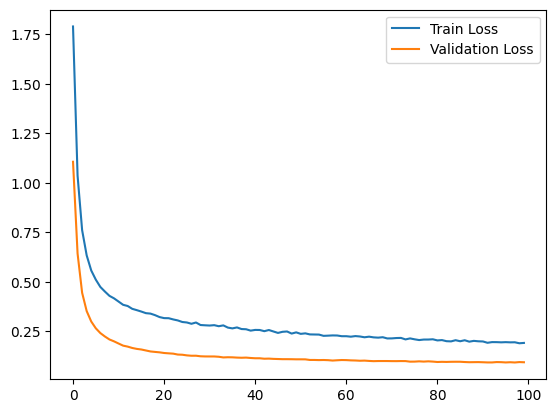

In [ ]:
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
for x_test, y_test in test_loader:
  x_test = torch.flatten(x_test, 2).squeeze(1)
  # 1st layer
  z1=x_test@w1+b1
  # 1st batch normalization
  mean1=z1.mean(0,keepdim=True)
  diff1=z1-mean1
  diff1_sqr=diff1**2.0
  diff1_sqr_mean=diff1_sqr.mean(0,keepdim=True)
  std1=torch.sqrt(diff1_sqr_mean)
  std1_inv=std1**-1.0
  batchnorm1=diff1*std1_inv
  batchout1=gamma1*batchnorm1+beta1
  # 1st activation
  leaky1=leaky_relu(batchout1)

  # 2nd layer
  z2=leaky1@w2+b2
  # 2nd batch normalization
  mean2=z2.mean(0,keepdim=True)
  diff2=z2-mean2
  diff2_sqr=diff2**2.0
  diff2_sqr_mean=diff2_sqr.mean(0,keepdim=True)
  std2=torch.sqrt(diff2_sqr_mean)
  std2_inv=std2**-1.0
  batchnorm2=diff2*std2_inv
  batchout2=gamma2*batchnorm2+beta2
  # 2nd activation
  leaky2=leaky_relu(batchout2)

  # output layer
  z3=leaky2@w3+b3
  z3_max=z3.max(1,keepdim=True).values
  norm_z3=z3-z3_max
  exp_z3=torch.exp(norm_z3)
  probs = exp_z3 / exp_z3.sum(dim=1, keepdim=True)

  # Predictions
  predictions = torch.argmax(probs, dim=1)
  correct += (predictions == y_test).sum().item()
  total += y_test.size(0)


accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.23%
